<a href="https://colab.research.google.com/github/dansainthedark/convert_image_to_sound/blob/main/Spectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# やりたいこと
- 音声から画像を生成
  - 音声の時間経過に連動して映像にできればベスト
- 画像から音声を生成
  - 単純なスペクトログラムからの生成では音楽的に使える音にならない


## 具体的な構想
- 画像のピクセル情報（座標）と音声（周波数、振幅、時間）の情報のマッピングを考える
- 画像、音声の特徴量を取り出して相互に紐づけたい
- 場合によってはDeep Learningで変換モデルを作る
  - 生成系なので意味不明のものが生まれても面白ければOK

## memo
- 参考記事
 - https://qiita.com/lilacs/items/a331a8933ec135f63ab
- datasets
  - https://magenta.tensorflow.org/datasets/nsynth#instrument-sources
  - https://research.google.com/audioset/dataset/drum_kit.html



# setup

In [ ]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import IPython.display
from IPython.display import display
import pandas as pd

import librosa
import librosa.display

import cv2

In [ ]:
# pyplotのデフォルト値を設定
plt.rcParams.update({
  'font.size' : 5
  ,'font.family' : 'Meiryo' if os.name == 'nt' else ''
  ,'figure.figsize' : [2.0, 1.0]
  ,'figure.dpi' : 300
  ,'savefig.dpi' : 300
  ,'figure.titlesize' : 'large'
  ,'legend.fontsize' : 'small'
  ,'axes.labelsize' : 'medium'
  ,'xtick.labelsize' : 'small'
  ,'ytick.labelsize' : 'small'
  })
# ndarrayの表示設定
np.set_printoptions(threshold=0)  # 可能ならndarrayを省略して表示
np.set_printoptions(edgeitems=1)  # 省略時に１つの要素だけ表示

# 音声テスト

In [ ]:
audio_path = librosa.util.example_audio_file(); audio_path

'/root/.cache/librosa/Kevin_MacLeod_-_Vibe_Ace.hq.ogg'

In [ ]:
SAMPLING_RATE:int = 44100
DURATION: float = 1.0
y, sr = librosa.load(audio_path,sr=SAMPLING_RATE, duration=DURATION)
display([type(y), y.shape], [type(sr), sr])

[numpy.ndarray, (44100,)]

[int, 44100]

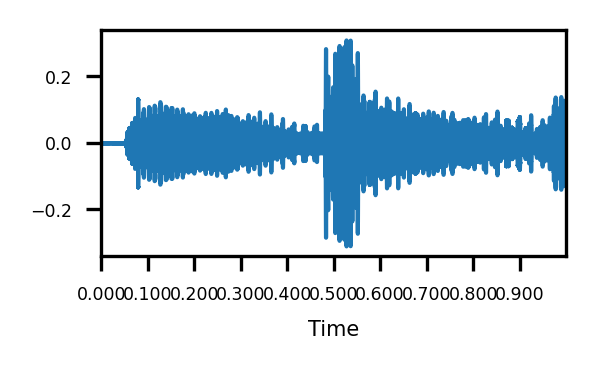

In [133]:
display(IPython.display.Audio(y, rate=sr))
mpl_collection = librosa.display.waveplot(y, sr=sr)

# Spectrogram

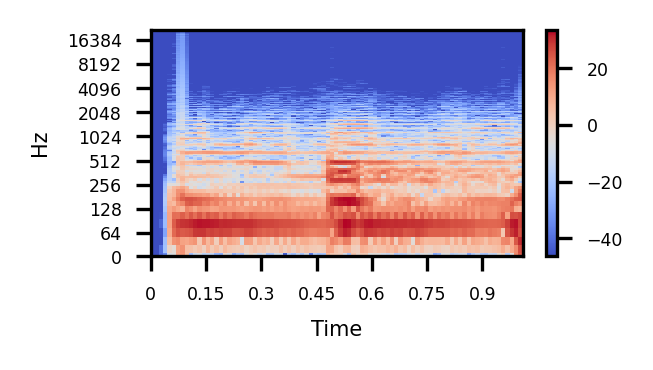

In [121]:
D = librosa.stft(y)
S, phase = librosa.magphase(D)  # 複素数を強度と位相へ変換
Sdb = librosa.amplitude_to_db(S)  # 強度をdb単位へ変換

librosa.display.specshow(Sdb, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

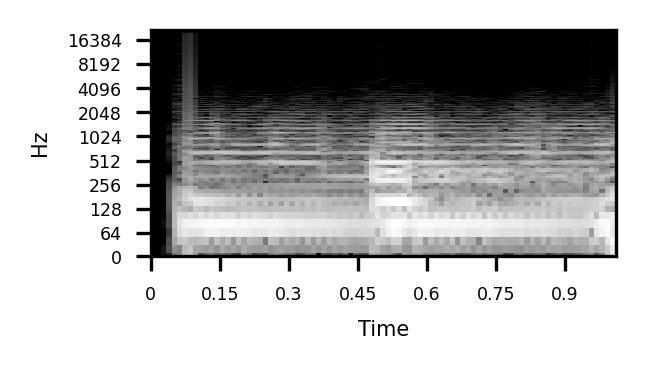

In [122]:
librosa.display.specshow(Sdb, sr=sr, hop_length=512, x_axis='time', y_axis='log', cmap='gray')
# TODO: 各軸の情報を表示せずplot部分だけ画像保存したい
plt.savefig("out.png")
plt.show()

## 強度(S)について



- 0Hz～約11kHzの範囲を約1025分割して表現（周波数分解能は約10.76Hz）
- １秒間を約87分割して表現

In [ ]:
display(type(S))
display(S)
display(S.shape)
display()

numpy.ndarray

array([[1.5149586e-04, ..., 1.6947483e+01],
       ...,
       [4.5219467e-11, ..., 1.3893925e-03]], dtype=float32)

(1025, 87)

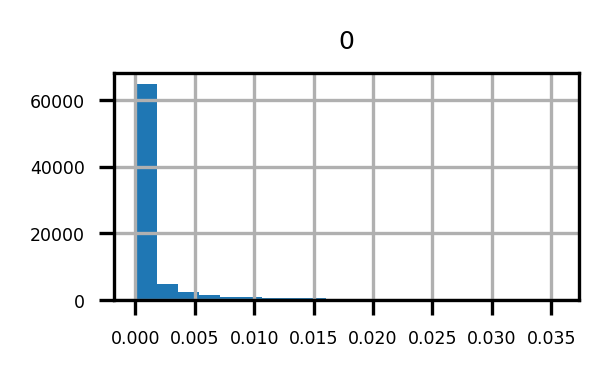

In [ ]:
s = pd.DataFrame(S.flatten())
s.hist(bins=20, range=(s.min().values[0], s.quantile(0.9).values[0]) ) # Sの最小値～90%点までの分布を表示
plt.show()

## 位相(phase)について

In [ ]:
print(type(phase), phase.shape)
print(phase)

<class 'numpy.ndarray'> (1025, 87)
[[-1.-8.742278e-08j ...  1.+0.000000e+00j]
 ...
 [-1.-8.742278e-08j ...  1.+0.000000e+00j]]


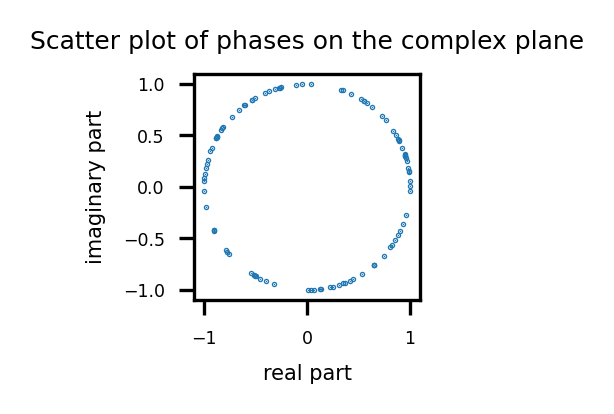

In [ ]:
p = pd.DataFrame(phase.flatten()).sample(n=100)  # 散布図にするにはデータ数多すぎなのでランダムサンプリング
mpl_collection = plt.scatter(np.real(p), np.imag(p), 0.1)
mpl_collection.axes.set(title="Scatter plot of phases on the complex plane", xlabel="real part", ylabel="imaginary part", aspect='equal')
plt.show()

# Image to Spectrogram
- 画像から強度情報を取り出す

In [138]:
from google.colab import files
uploaded = files.upload()

Saving colab_favicon_256px.png to colab_favicon_256px.png


In [139]:
uploaded_file_name = next(iter(uploaded))
im_gray = cv2.imread(uploaded_file_name, cv2.IMREAD_GRAYSCALE)
im_gray = cv2.resize(im_gray , (1025, 100))
display(im_gray)

array([[255, ..., 255],
       ...,
       [255, ..., 255]], dtype=uint8)

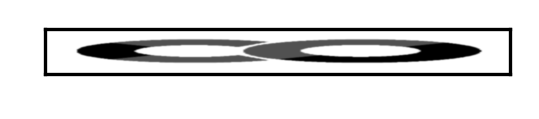

In [140]:
plt.imshow(im_gray, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

array([[0, ..., 0],
       ...,
       [0, ..., 0]], dtype=uint8)

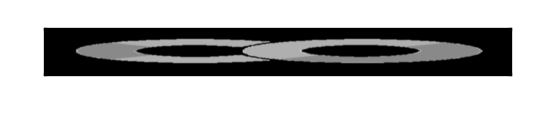

In [141]:
np.place(im_gray, im_gray==255, 0) # 画像に無駄な空白があるので黒に置き換え（本当はトリミングすべき）
display(im_gray)
plt.imshow(im_gray, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [142]:
S = librosa.amplitude_to_db(im_gray)
display(S)

array([[-56.03800653, ..., -56.03800653],
       ...,
       [-56.03800653, ..., -56.03800653]])

# Spectrogram to Sound

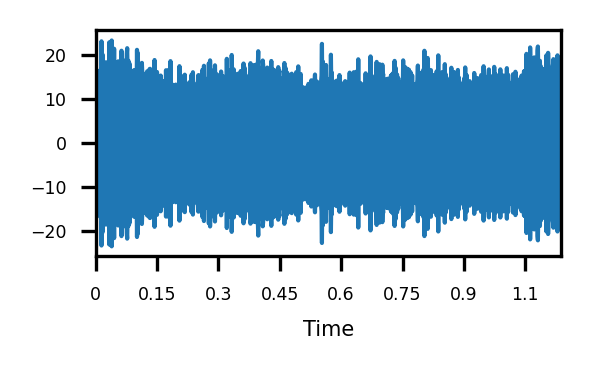

In [143]:
y_inv = librosa.griffinlim(S) # 位相の推定
display(IPython.display.Audio(y_inv, rate=sr))
mpl_collection = librosa.display.waveplot(y_inv, sr=sr)